*Link to Josh post about how to get into the field, as a reason on why I am not focusing on the Education level needed to get into tech. It is basically anwered  on his post*

- Evolution of Salary per countries. 
    - ***Where has it grown*** more. ----> Time series 
    - ***Where people code more as a hobby*** ('hobby'/number of coders for country). It shows an interesting insight of ***where to look for talent***.
    - What ***feature*** has ***more influence in the salary*** nowadays for the ***top 10 countries***(only 2018 survey). ---> Predictive model

- Evolution of Women in tech teams:
    - 'women_on_team' , 'gender' ---> Time series
    - Check correlation with:
        - 'company_size_range' 
        - 'agree_diversity' 
    - Salary comparison for whole population of men and women (2018)
    - Salary comparison for the top paids (2018)

- Tecnologies used, or WHAT TO LEARN TO GET INTO TECH?:
    - 'tech_do' What is growing, what is shrinking ---> Time series
    - 'agree_tech' filtrar por 'tech_do' to see what programming language seems to be more satisfying for proffesionals. Relation with 'Salary' could be interesting.   
    - 'important_newtech' How important is learning new techs. Crossing 'tech_want' and 'open_to_new_job' can show where proffesionals want to move towards. 

- Remote working:
    - 'remote' and 'important_wfh' evolution (¿per country multiline plot?) ----> Time series
    - Proportion of remote positions per country (2018)


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import warnings; warnings.simplefilter('ignore')

from collections import OrderedDict
from datetime import date


In [2]:
# Reading csv from survey files and storing them in a dictionary
dfs = {}
years = ['2011','2012','2013','2014','2015','2016','2017','2018']
for i in years:
    name = 'df_'+ i
    try:
        dfs[name] = df_i = pd.read_csv('./'+ i +'_survey_results.csv')
    except UnicodeDecodeError:
        dfs[name] = df_i = pd.read_csv('./'+ i +'_survey_results.csv', encoding = 'ISO-8859-1')

# Comparing shapes, I suspect they are not evenly organized
for year in list(dfs.keys()):
    print(dfs[year].shape)

(2814, 65)
(6244, 75)
(9743, 128)
(7644, 120)
(26087, 222)
(56030, 66)
(51392, 154)
(98855, 129)


**Working people**

We want to know the proportion of gender and programming languages used within tech proffesionals. For that, we need get rid of all the non-proffesional developers that filled the survey. For that let´s reduce the dataframes to only the people with a current salary. We can make a function but is a mess due to different column names in different dataframes.

In [3]:
# The column names for df_2015 are written in the first row of the dataset, let´s
# place them where they should be
dfs['df_2015'].columns = list(dfs['df_2015'].iloc[0,:])

In [4]:
years = ['2011','2012','2013','2014','2015','2016','2017','2018']
col_names = ['Including bonus, what is your annual compensation in USD?',
            'Including bonus, what is your annual compensation in USD?',
            'Including bonus, what is your annual compensation in USD?',
            'Including bonus, what is your annual compensation in USD?',
            'Compensation', 'salary_range', 'Salary', 'Salary']
no_salary_value = ['Student / Unemployed', 'Student / Unemployed',
                  'Student / Unemployed', 'Student / Unemployed',
                  'Unemployed', 'Unemployed', 'any', 'any']
year_dfs = {}
for year,col,no_salary_value in zip(years,col_names, no_salary_value):
    name = 'df_'+ year
    # drop rows where salary is null
    year_dfs[name] = dfs[name][dfs[name][col].isnull() == False]
    # drop rows where salary is == unemployed, student,etc
    # for all dfs values in salay are categorical, 2017 and 2018 are numbers
    if (year != '2017') and (year != '2018'): 
        year_dfs[name] = year_dfs[name][year_dfs[name][col] != no_salary_value]
    else:
        year_dfs[name] = year_dfs[name][year_dfs[name][col]!=0]
            

In [5]:
# Let´s check if it has worked
year_dfs['df_2016'][year_dfs['df_2016']['salary_range']=='Unemployed']

,Unnamed: 0,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,...,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow


**Next steps**

Now we already have a dictionary containing the 8 DataFrames with information just about working people with a real salary, no matters the range. From now on, we will wrangle the data in terms of gender and programming languages.

**Easing the path to analyze 8 DataFrames**

I want to inspect the information looking for the **evolution of women involvement in Tech**, and similarly with the **increase or decrease in the use of certain technologies**. It is going to be a mess as each survey is organized in a different manner. Let´s use the use the following script to look for the columns I need to create time series dataframes with info from different years.

In [6]:
# Inspect each df within the dictionary looking for the information
def inspect_dfs(keys, dictio):
    '''
    INPUT: 
        - keys(list of strings to be contained in any of the columns names)
        - dictio : dictionary with years as keys and corresponding Dataframes 
        as values.
    
    This function calculates the mode for each column of each DataFrame.
    Then it looks for the given keys along those modes, printing whether they
    are found or not, and where 
    '''
    for year in dictio.keys():
        new_df = dictio[year]
        # Drop non-object type columns as we will be comparing strings
        cat_df = dictio[year].select_dtypes(include = ['object'])
        print('YEAR {}'.format(year))

        for g_key in keys: 
            for col in cat_df.columns:
                try:
                    if g_key in cat_df[col].mode()[0]:
                        print('{} appears in column {}'.format(g_key,col))
                except IndexError:
                    continue

In [7]:
# Inspect for gender related columns in the 8 datasets
gender_keys = ['Male', 'male', 'Female', 'female',
               'Man', 'man', 'Woman', 'woman']

inspect_dfs(gender_keys, year_dfs)

YEAR df_2011
YEAR df_2012
YEAR df_2013
Man appears in column Unnamed: 11
man appears in column Unnamed: 18
YEAR df_2014
Male appears in column What is your gender?
YEAR df_2015
Male appears in column Gender
YEAR df_2016
Male appears in column gender
YEAR df_2017
Male appears in column Gender
YEAR df_2018
Male appears in column Gender
man appears in column EthicsResponsible


**Function to create a time series dataframe**

Once we have spotted where in each dataset we can find information related with whatever we are looking for, let´s extract this info and build a time series with it. The idea is to start the analysis with different features in time series, so let´s **build a function for that task**.

In [8]:
def create_time_series(years, col_names, source_dict):
    values = []
    for year,col_name in zip(years, col_names):
        name_df = 'df_'+year
        year_values = source_dict[name_df][col_name].value_counts().to_dict()
        values.append(year_values)    # store dictionaries in a list, to create the df by rows
    new_df = pd.DataFrame(values, index=years)
    return new_df

In [9]:
years = ['2014', '2015', '2016', '2017', '2018']
col_names = ['What is your gender?', 'Gender', 'gender', 'Gender', 'Gender']

gender_df = create_time_series(years, col_names, year_dfs)

In [10]:
female_df = pd.DataFrame()
male_df = pd.DataFrame()
others_df = pd.DataFrame()
for col in gender_df.columns:
    if ('Male' in col) and ('Female' not in col):
        male_df[col] = gender_df[col]
    if 'Female' in col:
        female_df[col] = gender_df[col]
    if ('Male' not in col) and ('Female' not in col):
        others_df[col] = gender_df[col]

male_df['total_males'] = male_df.sum(axis=1)
female_df['total_females'] = female_df.sum(axis=1)
others_df['total_others'] = others_df.sum(axis=1)

In [11]:
final_df = pd.DataFrame()
final_df['gender_males'] = male_df['total_males']
final_df['gender_females'] = female_df['total_females']
final_df['gender_other'] = others_df['total_others']
final_df['gender_total'] = final_df.sum(axis=1)
final_df['prop_males'] = [(i/j)*100 for i,j in zip(final_df['gender_males'], final_df['gender_total'])]
final_df['prop_females'] = [(i/j)*100 for i,j in zip(final_df['gender_females'], final_df['gender_total'])]
final_df['prop_other'] = [(i/j)*100 for i,j in zip(final_df['gender_other'], final_df['gender_total'])]

Text(0,0.5,'Percentage %')

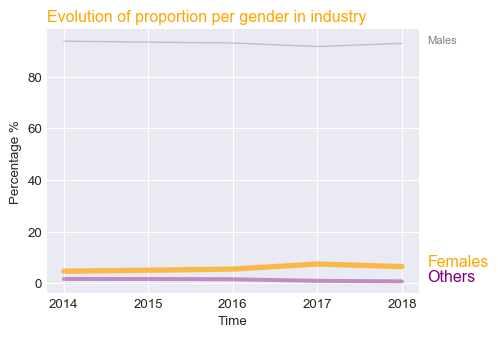

In [12]:
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-darkgrid')
my_dpi=96                               # DPI stands for DOTS PER INCH
plt.figure(figsize=(480/my_dpi, 350/my_dpi), dpi=my_dpi)
 
# multiple line plot
plt.plot(list(final_df.index), final_df['prop_males'], marker='', 
         color='grey', linewidth=1, alpha=0.4)
plt.plot(list(final_df.index), final_df['prop_other'], marker='', 
         color='purple', linewidth=3, alpha=0.4)
# Now re do the interesting curve, but biger with distinct color
plt.plot(list(final_df.index), final_df['prop_females'], marker='', 
         color='orange', linewidth=4, alpha=0.7)

# Change xlim
# plt.xlim(0,12)
 
# Let's annotate the plot
# num=0
# for i in df.values[9][1:]:
#    num+=1
#    name=list(df)[num]
#    if name != 'y5':
#       plt.text(10.2, i, name, horizontalalignment='left', size='small', color='grey')
 
plt.text(4.3, final_df.prop_males.tail(1), 
         'Males', horizontalalignment='left', size='small', color='grey')
plt.text(4.3, final_df.prop_other.tail(1), 
         'Others', horizontalalignment='left', size='large', color='purple')

# And add a special annotation for the group we are interested in
plt.text(4.3, final_df.prop_females.tail(1), 
         'Females', horizontalalignment='left', size='large', color='orange')
 
# Add titles
plt.title("Evolution of proportion per gender in industry", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Percentage %")


In [13]:
tech_lang_keys = ['Python', 'Java', 'Ruby',
               'Javascript', 'PHP', 'Woman', 'woman']

inspect_dfs(tech_lang_keys, year_dfs)

YEAR df_2011
Python appears in column Unnamed: 34
Java appears in column Which languages are you proficient in?
Java appears in column Unnamed: 31
Ruby appears in column Unnamed: 35
PHP appears in column Unnamed: 33
YEAR df_2012
Python appears in column Unnamed: 26
Java appears in column Which languages are you proficient in?
Java appears in column Unnamed: 23
Ruby appears in column Unnamed: 28
PHP appears in column Unnamed: 25
YEAR df_2013
Python appears in column Unnamed: 66
Java appears in column Unnamed: 59
Java appears in column Unnamed: 60
Ruby appears in column Unnamed: 67
PHP appears in column Unnamed: 65
YEAR df_2014
Python appears in column Unnamed: 50
Java appears in column Unnamed: 45
Java appears in column Unnamed: 46
Ruby appears in column Unnamed: 51
PHP appears in column Unnamed: 49
YEAR df_2015
Python appears in column Current Lang & Tech: Python
Python appears in column Future Lang & Tech: Python
Java appears in column Current Lang & Tech: Java
Java appears in column 

In [14]:
languages_2011 = {}
df_2011_lang = year_dfs['df_2011'].iloc[:,30:41]
for i, col in enumerate(df_2011_lang.columns):
    name = df_2011_lang.iloc[0,i].strip()
    languages_2011[name] = df_2011_lang[col].value_counts()[0]

In [15]:
languages_2012 = {}
df_2012_lang = year_dfs['df_2012'].iloc[:,22:35]
for i, col in enumerate(df_2012_lang.columns):
    name = df_2012_lang.iloc[0,i].strip()
    languages_2012[name] = df_2012_lang[col].value_counts()[0]

In [16]:
languages_2013 = {}
df_2013_lang = year_dfs['df_2013'].iloc[:,56:81]
for i, col in enumerate(df_2013_lang.columns):
    name = df_2013_lang.iloc[0,i].strip()
    languages_2013[name] = df_2013_lang[col].value_counts()[0]

In [17]:
languages_2014 = {}
df_2014_lang = year_dfs['df_2014'].iloc[:,42:67]
for i, col in enumerate(df_2014_lang.columns):
    name = df_2014_lang.iloc[0,i].strip()
    languages_2014[name] = df_2014_lang[col].value_counts()[0]

In [18]:
languages_2015 = {}
for i,col in enumerate(year_dfs['df_2015'].columns):
    if 'Current Lang & Tech' in col:
        name = col.split(':')[1].strip()
        a = year_dfs['df_2015'][col].value_counts()[0]
        languages_2015[name] = a        

In [19]:
languages_2016 = {}
for line in year_dfs['df_2016']['tech_do']:
    try:
        for lang in line.split(';'):
            lang = lang.strip()
            if lang not in languages_2016.keys():
                languages_2016[lang] = 1
            if lang in languages_2016.keys():
                languages_2016[lang] += 1
    except AttributeError:
        continue

In [20]:
languages_2017 = {}
for line in year_dfs['df_2017']['HaveWorkedLanguage']:
    try:
        for lang in line.split(';'):
            lang = lang.strip()
            if lang not in languages_2017.keys():
                languages_2017[lang] = 1
            if lang in languages_2017.keys():
                languages_2017[lang] += 1
    except AttributeError:
        continue

In [21]:
languages_2018 = {}
for line in year_dfs['df_2018']['LanguageWorkedWith']:
    try:
        for lang in line.split(';'):
            lang = lang.strip()
            if lang not in languages_2018.keys():
                languages_2018[lang] = 1
            if lang in languages_2018.keys():
                languages_2018[lang] += 1
    except AttributeError:
        continue


In [22]:
df_lang = pd.DataFrame([languages_2011, languages_2012, languages_2013,
                        languages_2014, languages_2015, languages_2016,
                        languages_2017, languages_2018], 
                        index = ['2011','2012','2013','2014',
                                 '2015','2016','2017','2018'])
# df_lang = df_lang.drop('Dart', axis=1)
# Drop columns(languages) with more than 50% of missing values
df_lang = df_lang.loc[:, df_lang.isnull().mean() < 0.5]
# Calculate total developers per year
df_lang['total'] = df_lang.sum(axis=1)
# Replace abs.values for proportions to the total of each year
for col in (df_lang.drop('total', axis=1).columns):
    df_lang[col] = [(i/j)*100 for i,j in zip(df_lang[col], df_lang['total'])]

For the sake oh the multiple lineplot we´re planning to create, let´s input values to the missing ones:
- Use the interpolate function to input values in missing points building a straight line from the previous and next known values. This doesn´t work if we don´t have either previous or next values.
- For missing values in older years with no previous information, is maybe better to leave as they are rathe than imputing invented values we don´t really know. They will start 'later' in the time series lineplot.

In [23]:
for col in df_lang.columns: 
    if df_lang[col].isnull().sum() != 0:
        df_lang[col].interpolate(method='linear', inplace=True)

In [24]:
df_lang

,C,C#,C++,CoffeeScript,Dart,F#,Go,Haskell,Java,JavaScript,Objective-C,PHP,Perl,Python,Ruby,SQL,total
2011,8.227147,16.024931,8.047091,NaN,NaN,NaN,NaN,NaN,9.819945,16.675900,NaN,8.850416,3.490305,6.357341,3.157895,19.349030,7220.0
2012,7.388981,13.395983,7.579387,NaN,NaN,NaN,NaN,NaN,11.983293,16.768012,3.101775,9.993244,2.530557,6.154413,3.052638,18.051717,16281.0
2013,4.664366,11.581433,5.568171,3.769643,1.503315,2.357162,NaN,3.120174,10.595876,17.948951,3.519847,8.302298,2.098294,6.412935,2.906713,17.749114,22018.0
2014,4.794873,11.701093,5.859129,2.517595,1.522000,2.454655,2.878068,2.752189,10.768439,18.058019,3.272873,7.426904,1.666032,6.208159,2.775076,17.010929,17477.0
2015,5.155536,11.518547,6.545043,1.349055,0.169896,0.291250,0.784758,0.473282,12.487359,19.944582,2.930707,10.343433,1.233769,8.017475,2.959023,15.796287,49442.0
2016,5.143449,11.160451,6.470764,1.261799,0.162578,0.368834,1.159076,0.552442,12.609093,20.144298,2.402271,9.213559,1.199518,8.665162,3.291192,16.195514,123633.0
2017,4.421064,12.064125,5.683100,1.130848,0.139060,0.446042,1.537533,0.369953,11.993283,21.328681,2.240705,8.083856,1.167581,9.031039,3.274473,17.088657,38113.0
2018,5.493197,9.970674,6.331951,1.028640,0.139060,0.437636,2.144920,0.685386,12.051550,20.076741,1.987056,8.227436,1.183695,10.776845,3.097156,16.507118,178002.0


In [25]:
df_lang[col].tail(1)[0] > 5

True

Text(0,0.5,'Percentage %')

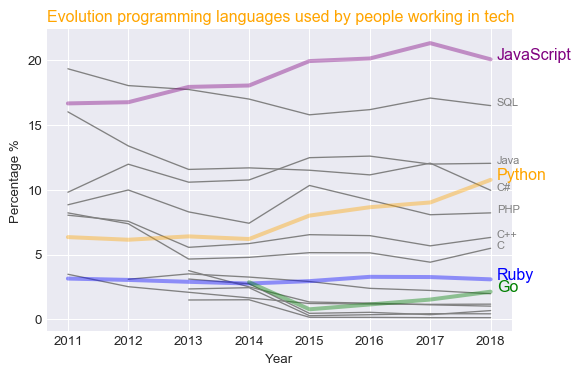

In [26]:
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-darkgrid')
my_dpi=96                               # DPI stands for DOTS PER INCH
plt.figure(figsize=(600/my_dpi, 400/my_dpi), dpi=my_dpi)
interesting_curves = ['Python','JavaScript','Ruby','Go']
colors = ['orange', 'purple','blue', 'green']

# multiple line plot
for col in df_lang.drop(interesting_curves + ['total'], axis=1).columns:
    plt.plot(list(df_lang.index), df_lang[col], marker='', 
             color='grey', linewidth=1, alpha=4) 
# plotting INTERESTING CURVES
for col, color in zip(interesting_curves, colors):
    plt.plot(list(df_lang.index), df_lang[col], marker='',
             color = color, linewidth=3, alpha=0.4)
# Annotations for each plotline
for col in df_lang.drop(interesting_curves + ['total'], axis=1).columns:
    if df_lang[col].tail(1)[0] > 5:
        plt.text(7.1, df_lang[col].tail(1), 
                 col, horizontalalignment='left', size='small', color='grey')      
# Annotations for INTERESTING CURVES  
for col, color in zip(interesting_curves, colors):
    plt.text(7.1, df_lang[col].tail(1), 
             col, horizontalalignment='left', size='large', color=color)
             
# Add titles
plt.title("Evolution programming languages used by people working in tech", 
          loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Year")
plt.ylabel("Percentage %")

**Analyze last year information**

Now that we know about both features have evoluted along the years, let´s focus on the last DataFrame to get deeper what kind of companies, job roles, etc women are placed in. Let´s change from time-series to a less dynamic type of data.

**First, let´s create a DataFrame contining just instances for females, and other one just for males.**

In [27]:
# Reduce the number of different gender categories to just Male, Female and Other
def split_males_females(df):
    female_values_replace = []
    others_values_replace = []
    for gender in df[df['Gender'] != 'Female']['Gender']: 
        try:
            if ('Female' in gender) and (gender not in female_values_replace):
                female_values_replace.append(gender)
            if gender != 'Male':
                others_values_replace.append(gender)
        except TypeError:
            continue

    df['Gender'].replace(female_values_replace, 'Female', inplace=True)
    df['Gender'].replace(others_values_replace, 'Other', inplace=True)
    df_females = df[df['Gender'] == 'Female']
    df_males = df[df['Gender'] == 'Male']
    return df_males, df_females

In [28]:
df_2018_males, df_2018_females = split_males_females(year_dfs['df_2018'])

Now we can start analyzing what happens when **inspecting different features** as: Country, FormalEducation, CompanySize, YearsCoding, LanguageWorkedWith, DevType

In [29]:
def create_df_proportions_between_genders(df_female, df_male, feature): 
    females_info = dict(df_2018_females[feature].value_counts()[:15])
    males_info = dict(df_2018_males[feature].value_counts()[:15])
    df_gender_feature = pd.DataFrame([females_info, males_info], 
                     index= ['Female', 'Male']).dropna(how = 'any', axis=1)
    for feat in df_gender_feature.columns:
        total_feat = df_gender_feature[feat].sum(axis=0)
        df_gender_feature[feat] = [(i/total_feat)*100 
                                      for i in df_gender_feature[feat]]
    final = df_gender_feature.sort_values('Female', axis=1, ascending = False)
    return final

As **'DevType'** and **'LanguageWorkedWith'** are answered in batches, **let´s build a function to split them and count.**

In [30]:
def split_progr_lang(df, feat_name):
    lang_usage = {}
    for item in list(df[feat_name]):
        try:
            for lang in item.split(';'):
                if lang not in lang_usage.keys():
                    lang_usage[lang] = 1
                else:
                    lang_usage[lang] += 1
        except AttributeError:
            continue
    return lang_usage

In [31]:
# Build a DataFrame with proportions of genders per programming language
female_lang_usage = split_progr_lang(df_2018_females, 'LanguageWorkedWith')
male_lang_usage = split_progr_lang(df_2018_males, 'LanguageWorkedWith')

df_gender_lang = pd.DataFrame([female_lang_usage, male_lang_usage], 
                     index= ['Female', 'Male']).dropna(how = 'any', axis=1)
for lang in df_gender_lang.columns:
    total_lang = df_gender_lang[lang].sum(axis=0)
    df_gender_lang[lang] = [(i/total_lang)*100 
                                  for i in df_gender_lang[lang]]

In [32]:
# Build a DataFrame with proportions of genders per type of developer
female_dev_type = split_progr_lang(df_2018_females, 'DevType')
male_dev_type = split_progr_lang(df_2018_males, 'DevType')

df_gender_dev = pd.DataFrame([female_dev_type, male_dev_type], 
                     index= ['Female', 'Male']).dropna(how = 'any', axis=1)
for dev in df_gender_dev.columns:
    total_dev = df_gender_dev[dev].sum(axis=0)
    df_gender_dev[dev] = [(i/total_dev)*100 
                                  for i in df_gender_dev[dev]]

In [33]:
df_gender_lang = df_gender_lang.sort_values('Female', axis=1, ascending = False)

df_gender_dev = df_gender_dev.sort_values('Female', axis=1, ascending = False)

df_gender_CompanySize = create_df_proportions_between_genders(df_2018_females, 
                                                df_2018_males, 'CompanySize')
df_gender_country = create_df_proportions_between_genders(df_2018_females, 
                                                df_2018_males, 'Country')
df_gender_education = create_df_proportions_between_genders(df_2018_females, 
                                                df_2018_males, 'FormalEducation')
df_gender_YearsCoding = create_df_proportions_between_genders(df_2018_females, 
                                                df_2018_males, 'YearsCoding')

In [34]:
df_gender_dev

,Educator or academic researcher,Marketing or sales professional,QA or test developer,Student,Data scientist or machine learning specialist,Designer,Data or business analyst,Front-end developer,Mobile developer,Product manager,Full-stack developer,Back-end developer,Game or graphics developer,Database administrator,Desktop or enterprise applications developer,Engineering manager,Embedded applications or devices developer,DevOps specialist,System administrator,"C-suite executive (CEO, CTO, etc.)"
Female,9.521028,7.939914,7.65688,7.614108,7.386209,6.699011,6.396966,6.386841,5.561662,5.366075,5.265702,5.082605,4.566684,4.53573,4.127021,4.102384,3.828484,3.686248,3.164444,2.658228
Male,90.478972,92.060086,92.34312,92.385892,92.613791,93.300989,93.603034,93.613159,94.438338,94.633925,94.734298,94.917395,95.433316,95.46427,95.872979,95.897616,96.171516,96.313752,96.835556,97.341772


## What factors have a greater influence in the salary of a person?
### Do they influence differently to women and men?
- Let´s write a function (clean_data) to clean the data, considering dropping unnecesary columns, and handling missing values. For numerical columns we will input the mean of the feature, for categorical columns we´ll convert them into dummy variables.
- Create one more function (find_optimal_lm_mod) to split data into train and test, instantiate a Linear Regression model, fit, predict and score such model. It will perform these tasks for a different amount of features, and plot the score of the model both in training and testig sets, to spot the best point of accuracy and avoid overfitting.
- Apply the clean_data function and find_optimal_lm_mod funtion both to male and female dfs for the year 2018.
- Compare coefficients from both models to realize what influence they have on the salary of a woman or a man. There will be any difference?

In [39]:
df_2017_males, df_2017_females = split_males_females(year_dfs['df_2017'])

In [41]:
def clean_data(df):
    new_df = df[df['Salary'].isnull() == False]
    X = new_df.drop('Salary', axis=1)
    y = new_df['Salary']
    X.drop(['Respondent', 'ExpectedSalary'], axis = 1, inplace =True)
    
    num_cols = X.select_dtypes(include=['float', 'int']).columns
    print('there are {} numerical columns'.format(len(num_cols)))
    for col in num_cols:
        try:
            X[col].fillna(X[col].mean(), inplace=True)
        except:
            continue 
    
    cat_cols = list(X.select_dtypes(include = ['object']).copy().columns)
    for col in cat_cols:
        try:
            X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix = col, prefix_sep = '_', drop_first=True)], axis = 1)   
        except:
            continue
    return X, y

In [36]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test


In [42]:
X, y = clean_data(df_2017_females)

there are 4 numerical columns


In [ ]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [ ]:
df_2017_males, df_2017_females

In [38]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

ValueError: could not convert string to float: '72,500.00'